The Expectation-Maximization algorithm (EM algorithm) is a an algorithm that anyone learning about statistics or ML will probably hear about eventually. It is used to fit a parameterized distribution to observed data. However the underlying workings of it (at least to me) seem far more convoluted than a method such as gradient descent on the likelihood function. So we're going to go through a careful investigation of how it works.

To start with we need to set up the problem: Suppose we are given a bunch of data $X$ and wish build a model of the distribution that generates this data. To do this we'll suppose the distribution belongs to a family of distributions $P(X;\theta)$ where $\theta$ is some parameter. We'll also including in our model some <i>latent</i> or unobserved data, $Z$. Thus our full parametrized model is $P(X,Z;\theta)$. $Z$ represents some additional structure in the data that is not provided by $X$ but may be important in generating $X$. For example, if $X$ is a set of audio files of different birds, $Z$ could be the species of bird that produced each file. 

Associated to any $X$ and $Z$ we define the likelihood function:
$$
L(\theta;X,Z)  = P(X,Z;\theta)
$$
and given any $X$ the marginal likelihood is given by
$$
L(\theta;X)=\sum_Z P(X,Z;\theta)
$$
which is just the probability of observing the data $X$ marginalized over all possible $Z$ values. We want to find the <a href=https://en.wikipedia.org/wiki/Maximum_likelihood>maximum likelihood estimate</a>, which is just a way of saying that we believe the "best" value to choose for $\theta$ is the one that is most likely to produce our observed data:
$$
\theta^* = \argmax_\theta L(\theta;X)
$$

Unfortunately, the likelihood function $L(X;\theta)$ may not be so easy to compute - there may be an extremely large number of possible values for $Z$, in which case the sum in the previous equation becomes huge. Further, even when it is easy to compute the likelihood it may not be easy to compute the argmax to get $\theta^*$. The point of EM is to provide a workaround for this issue. It doesn't work perfectly in that it is not guaranteed to provide the actual maximum likelihood estimate, but it may work well in practice.

To be concrete, let's consider modeling human height. Male and female heights are approximately normally distributed, and each person has a $50\%$ chance of being male or female. That is, heights can be fit with a <a href=https://en.wikipedia.org/wiki/Mixture_model><i>Gaussian mixture model</i></a>. In this scenario, we assume that our data is generated by a fixed number of Gaussian distributions (in our case, 2). So our parameters are $\mu_0$, $\mu_1$, $\sigma_0$, $\sigma_1$, $\pi_0$, $\pi_1$ where $\mu_0$ is the average height of a male, $\sigma_1$ is the variance in female heights, and $\pi_0$ is the probability that any given person is a male. Of course we expect $\pi_0=\pi_1=0.5$, but for now let's pretend that we don't know that. Then our data $X=x_1,\dots,x_N$ will be a set of observed human heights. The latent data $Z=z_1,\dots,z_N$ is the gender of the observations ($z_i=1$ if the gender of the person with height $x_i$ is female, and 0 otherwise). 

Let's generate some simulated height data. Means and standard devaiations for male and female heights were pulled from <a href=www.wolframalpha.com/>Wolfram Alpha</a>.


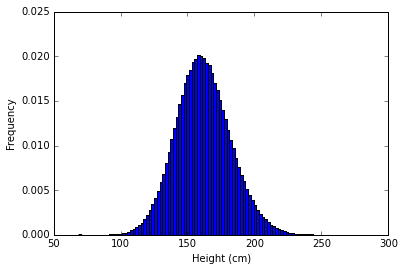

In [1]:
# <!-- collapse=False -->
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def GenHeights(N):
    def getheight():
        g = np.random.choice(['male','female'])
        if(g=='male'):
            return np.random.normal(167,22)
        if(g=='female'):
            return np.random.normal(156,17)
    return np.array([getheight() for i in xrange(N)])

X = GenHeights(1000000)
plt.hist(X,100,normed = 1)
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()

Notice that it's not really obvious from inspection that this is a mixture of two normal distributions, but nevertheless we'll hopefully be able to extract the relevant male and female height statistics.

The EM algorithm is an iterative procedure; given a starting estimate of the parameters, $\theta_0$, we will generate a series of estimates $\theta_1,\theta_2,\dots,\theta_t$ such that $L(\theta_t;X)$ gets closer to the maximum likelihood $L(\theta^*;X)$ as $t\to\infty$. With this in mind, suppose that we have some current estimate of the parameter, $\theta_t$. We'll describe how to obtain $\theta_{t+1}$.

First define the function
$$
Q(\theta|\theta_t)=Q_t(\theta) = \E_{Z|X,\theta_t}[\log(L(\theta;X,Z))] = \sum_Z P(Z|X;\theta_t)\log(L(\theta;X,Z))
$$
where 
$P(Z|X;\theta_t)$ is the conditional probability of $Z$ given the data $X$ and the parameter $\theta_t$. By Bayes' theorem:
$$
P(Z|X,\theta_t) = \frac{P(X,Z;\theta_t)}{\sum_{Z}P(X,Z;\theta_t)}
$$
This is called the "E" or Expectation step. Most people use the $Q(\theta|\theta_t)$ notation. I found $Q_t(\theta)$ was a little clearer for me when working through this so I'm going to use that for the remainder of this document.

Then set
$$
\theta_{t+1} = \argmax_{\theta} Q_t(\theta)
$$
This is called the "M" or Maximization step. And that's it! Just repeat this over and over.

Note that this $Q_t$ function seems to have the same difficulty that computing the likelihood $L(\theta;X)$ had - we have to compute a sum over $Z$. We're going to hope that for whatever examples we are interested in it's actually easy to compute $\theta_{t+1}$ due to some nice structure our model that allows us to avoid computing the sum by brute force.

Now this whole scheme may seem a bit arcane, so let's try to get a general sense of what's going on and why it's a good idea. Consider the following scheme: 

<ol>
<li> Given $X,\theta_t$, we get a distribution over possible $Z$'s - $P(Z|X;\theta_t)$. Now let's actually pick a $Z$ from this distribution and assume that it is correct.</li>
<li>Then given these values of $Z$, choose $\theta_{t+1}$ to maximize the overall likelihood function $L(\theta;X,Z)$. Since we've already picked $Z$ in a "greedy" manner, there is no need to marginalize over it to compute $L(\theta;X)$ - in fact if our choice of $Z$ is correct, it is actually <i>better</i> not to marginalize over all $Z$s.</li>
</ol>

The EM algorithm is essentially performing an averaged version of the two steps above. Instead of actually committing to a greedy choice of $Z$, we average over all possible greedy choices of $Z$ and pick the $\theta_t$ that will maximize this average. 

Let's work though what all this boils down to in the Gaussian mixture height model. We have 
$$
L(\theta;X,Z)=P(X,Z;\theta) = \prod_{i=1}^N z_i \frac{\pi_1}{\sigma_1\sqrt{2\pi} } \exp\left[ -\frac{(x-\mu_1)^2}{2\sigma_1^2}\right] +(1-z_i)\frac{\pi_0}{\sigma_0\sqrt{2\pi} } \exp\left[ -\frac{(x-\mu_0)^2}{2\sigma_0^2} \right]
$$
$$
\log(L(\theta;X,Z)) = \sum_{i=1}^N z_i\left(\log(\pi_1)-\log(\sigma_1\sqrt{2\pi})-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)+(1-z_i)\left(\log(\pi_0)-\log(\sigma_0\sqrt{2\pi})-\frac{(x-\mu_0)^2}{2\sigma_0^2}\right)
$$
$$
P(z_i=j|X,\theta_t) =  \frac{\pi_j^{(t)} \ p(x_i;\mu_j^{(t)},\sigma_j^{(t)})}{\pi_1^{(t)} \ p(x_i;\mu_1^{(t)},\sigma_1^{(t)}) + \pi_0^{(t)} \ p(x_i;\mu_0^{(t)},\sigma_0^{(t)})} 
$$
where 
$$
p(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]
$$
is the Gaussian density function and we are using $\theta_t = (\pi_1^{(t)},\mu_1^{(t)},\sigma_1^{(t)},\pi_2^{(t)},\dots)$.
Putting this together we have
$$
Q_t(\theta) = \sum_{i=1}^N p(z_i=1|X,\theta_t)\left(\log(\pi_1)-\log(\sigma_1\sqrt{2\pi})-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)+p(z_i=0|X,\theta_t)\left(\log(\pi_0)-\log(\sigma_0\sqrt{2\pi})-\frac{(x-\mu_0)^2}{2\sigma_0^2}\right)
$$

Notice that since we assume $z_i$ and $z_j$ are independent, $Q_t(\theta)$ is actually only a linear sum; if our model were more complicated it might become a very difficult exponential sum. It is not actually necessary to compute $Q_t(\theta)$ in this case. For the M step, we only want to maximize it. So let's do that. Note that the $\pi_j$s appear only in the $\log(\pi_j)$ term and so can be maximized seperately. We have $\sum_j \pi_j=1$, so using Lagrange multipliers:
$$
\frac{d Q_t(\theta)}{d \pi_j} = \frac{1}{\pi_j}\sum_{i=1}^Np(z_i=j|X,\theta_t)=\lambda
$$
$$
\pi_j = \lambda \sum_{i=1}^Np(z_i=j|X,\theta_t)=\frac{1}{N}\sum_{i=1}^Np(z_i=j|X,\theta_t)
$$

Further, we can maximize $\mu_0,\ \sigma_0$ independently of $\mu_1,\ \sigma_1$. So let's do that:
$$
\frac{d Q_t(\theta)}{d\mu_0} = \sum_{i=1}^N p(z_i=0|X,\theta_t) \left(-\frac{x_i-\mu_0}{\sigma_0^2}\right)
$$
$$
\frac{d Q_t(\theta)}{d\sigma_0} = \sum_{i=1}^N p(z_i=0|X,\theta_t) \left(\frac{(x_i-\mu_0)^2}{\sigma_0^3}-\frac{1}{\sigma_0}\right)
$$
From the first equation we have
$$
\mu_0=\frac{\sum_{i=1}^N p(z_i=0|X,\theta_t) x_i}{\sum_{i=1}^N p(z_i=0|X,\theta_t)}
$$
and so from the second we have
$$
\sigma_0 = \sqrt{\frac{\sum_{i=1}^N p(z_i=0|X,\theta_t)(x_i-\mu_0)^2}{\sum_{i=1}^Np(z_i=0|X,\theta_t)}}
$$
$\mu_1$ and $\sigma_1$ have similar updates from symmetry. 

For another (essentially similar) working through of the Gaussian mixture EM steps you can check out the <a href=https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm#Gaussian_mixture>example in the wikipedia article</a>.

Intuitively, these updates are actually very reasonable. $\pi_j$ is updated to be an estimate of how often $z_i=j$. $\mu_j$ is updated to an estimate of the mean of all the $x_i$s for which $z_i=j$, and $\sigma_j$ is updated to be the standard deviation of the same. Anyway, here it is in code. I'm going to try to spell out a lot of the variable assignments in order to make it clearer what's happening.

In [2]:
# <!-- collapse=False -->
import scipy.stats
def pdf(x,mu,sigma):
    """Gaussian pdf with mean x and standard deviation sigma"""
    return scipy.stats.norm(loc=mu,scale=sigma).pdf(x)

def Pz(X,pi0,pi1,mu0,mu1,s0,s1):
    """Returns a matrix of value for p(z_i=j|X,\theta_t). 
       Assumes X is an array containing all of the data"""
    p0 = pi0*pdf(X,mu0,s0)
    p1 = pi1*pdf(X,mu1,s1)
    pnorm = p0+p1
    assert(np.shape( np.array([p0/pnorm,p1/pnorm])) == (2,len(X)))
    return np.array([p0/pnorm,p1/pnorm])

    
def Update(X,_pi0,_pi1,_mu0,_mu1,_s0,_s1):
    """EM update step"""
    P = Pz(X,_pi0,_pi1,_mu0,_mu1,_s0,_s1)
    pi0 = np.average(P[0])
    pi1 = np.average(P[1])
    
    mu = np.dot(P,X)/np.sum(P,axis=1)
    mu0 = mu[0]
    mu1 = mu[1]
    
    sigma0 = np.sqrt(np.sum(P[0]*(X-mu0)**2)/np.sum(P,axis = 1)[0])
    sigma1 = np.sqrt(np.sum(P[1]*(X-mu1)**2)/np.sum(P,axis = 1)[1])
    
    return pi0,pi1,mu0,mu1,sigma0,sigma1

def RunEM(X,numiter,disp=0):
    """Run EM algorithm for mixture of two Gaussians for numiter iterations, 
       printing output every disp iterations.
       Initial values are chosen randomly. 
       There is no rationale for the variances in the initialization; 
       I basically just picked some numbers at random."""
    mu0= np.random.normal(np.average(X),10)
    mu1= np.random.normal(np.average(X),10)
    s0 = np.sqrt(np.average(X**2)-np.average(X)**2)
    s1 = np.random.normal(s0,3)
    pi0 = np.random.uniform(0,1)
    pi1 = 1- pi0
    for i in xrange(numiter):
        pi0,pi1,mu0,mu1,s0,s1 = Update(X,pi0,pi1,mu0,mu1,s0,s1)
        if(disp>0):
            if(i%disp ==0):
                print "On iteration "+str(i)+": theta="+str((pi0,pi1,mu0,mu1,s0,s1))
    return pi0,pi1,mu0,mu1,s0,s1
    

pi0,pi1,mu0,mu1,s0,s1 = RunEM(X,1000)
if(mu0>mu1): #Let's assume that the average male is taller than the average female
    (pim,pif,mum,muf,sm,sf) = (pi0,pi1,mu0,mu1,s0,s1)
else:
    (pim,pif,mum,muf,sm,sf) = (pi1,pi0,mu1,mu0,s1,s0)
    
print "Male statistics: (learned, actual)"
print "Probability of being male: %.2f, %.2f" %(pim,0.5)
print "Average Height: %.1f, %.1f" %(mum,167)
print "Height Std Dev: %.1f, %.1f" %(sm,22)

print "\nFemale statistics: (learned, actual)"
print "Probability of being female: %.2f, %.2f" %(pif,0.5)
print "Average Height: %.1f, %.1f" %(muf,156)
print "Height Std Dev: %.1f, %.1f" %(sf,17)


Male statistics: (learned, actual)
Probability of being male: 0.54, 0.50
Average Height: 166.6, 167.0
Height Std Dev: 22.0, 22.0

Female statistics: (learned, actual)
Probability of being female: 0.46, 0.50
Average Height: 155.6, 156.0
Height Std Dev: 16.7, 17.0


So that worked pretty well! To finish up, let's prove something about why we should expect the EM algorithm to work.

Now since the likelihood $L(\theta;X)$ is generally a non-convex function we probably can't expect any guarantee that we'll converge to the actual maximum (indeed if you run the Height data multiple times, occasionally it gets caught in a local minimum in which it tries to fit the data with a single Gaussian by setting $pi_j=0$ for some $j$). So instead what we will show is that $L(\theta;X)$ increases at every iteration of the algorithm.

As a first step to get intuition, let's consider the case in which the EM algorithm can't go any further - that is when $\theta_{t+1}=\argmax_{\theta} Q_t(\theta) = \theta_t$. In this case we have
$$
\begin{align*}
\nabla_\theta Q_t(\theta_t) &= 0\\
\sum_{Z} \frac{p(X,Z;\theta_t)}{p(X;\theta_t)}\frac{\nabla_\theta P(X,Z|\theta_t)}{p(X,Z;\theta_t)}&=0\\
\frac{1}{p(X;\theta_t)}\sum_{Z} \nabla_\theta p(X,Z;\theta_t)&=0\\
\nabla_\theta L(\theta_t;X) &=0
\end{align*}
$$
so that any local optimum for the EM algorithm is necessarily a local optimum of the overall likelihood.

This suggests (but does not prove yet!) that the sequence of $\theta_t$s produced by the EM algorithm should have a sequence of likelihoods $L(\theta_t;X)$ that converge to a local maximum of $L(\theta;X)$. Let's go one step further and show that the EM algorithm will always increase the likelihood at every iteration
For any given $Z$, we have
$$
p(X;\theta)p(Z;X,\theta) = p(X,Z;\theta)
$$
so that
$$
\begin{align*}
\log L(\theta;X)=\log(p(X;\theta)) &= \log(p(X,Z;\theta)-\log(p(Z;X,\theta))\\
&=\log L(\theta;X,Z) -\log(p(Z|X;\theta))
\end{align*}
$$
Now taking expectations over $Z$ given $X$ and $\theta_t$ should not change the left-hand side since it is a constant. Therefore:
$$
\log L(\theta;X) = Q_t(\theta) - \E_{Z|X,\theta_t}\log(p(Z;X,\theta))
$$
Then we have
$$
\log L(\theta_{t+1};X)-\log L(\theta_t;X) = Q_t(\theta_{t+1})-Q_t(\theta_t)\\ 
+\E_{Z|X,\theta_t}\log(p(Z|X;\theta_{t}))- \E_{Z|X;\theta_t}\log(p(Z|X,\theta_{t+1}))\\
=\left(Q_t(\theta_{t+1})-Q_t(\theta_t)\right) +\E_{Z|X,\theta_t}\left[\log\frac{p(Z|X;\theta_{t})}{p(Z|X,\theta_{t+1})}\right]
$$




The first difference on the right hand side is $\ge 0$ by definition of $\theta_{t+1}$ ($\theta_{t+1}$ maximizes $Q_t(\theta)$). The last term is actually the <a href=https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence>KL divergence</a> between $p(Z|X;\theta_t)$ and $p(Z|X;\theta_{t+1})$ and so must also be $\ge 0$. Together this implies that $L(\theta_{t+1};X)\ge L(\theta_t;X)$ and so the EM algorithm constantly increases the likelihood. Just to be a little more comprehensive, we'll lay out the KL divergence argument here:

Define the KL divergence between two distributions $P$ and $Q$ as
$$
KL(P\|Q) = \E_P[\log(P/Q)] = \sum_{X} P(X)\log\frac{P(X)}{Q(X)}
$$
Then via an application of <a href=https://en.wikipedia.org/wiki/Jensen%27s_inequality>Jensen's inequality</a> we have
$$
-KL(P\|Q) = \E_P[\log(Q/P)]\le \log[\E_P[Q/P]]=\log(1)=0
$$

The EM algorithm generates a sequence of $\theta_t$s such that $L(\theta_t;X)$ is constantly increasing. Thus if we 
assume that there actually is a maximum likelihood estimate $\theta_* = \argmax_{\theta} L(\theta;X)$, then $L(\theta_t;X)$ must converge to some value. Note that this is <i>NOT</i> the same as saying that $\theta_t$ converges. For more on when you can expect $\theta_t$ itself to converge, see Jeff Wu's paper "On the convergence properties of the EM algorithm". A pdf is <a href=http://artishoke.com/papers/ML/EMconvergence.pdf>here</a>.